<a href="https://colab.research.google.com/github/Puneeth006/Deep_Learning_Fundamentals/blob/main/Deep_Learning_Fundamentals_Assessment_2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Fundamentals Assessment 2

# Convolutional Nueral Networks

## 1. Load the data

### Import the data

In [ ]:
# Ensure Python version is at least 3.5
import sys
assert sys.version_info >= (3, 5)

# Libraries for data manipulation and computations
import numpy as np
import os, time
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt

# PyTorch libraries for neural network operations
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# PyTorch's torchvision for computer vision tasks
import torchvision
import torchvision.transforms as transforms

# Suppress unwanted warnings during execution
import warnings
warnings.filterwarnings('ignore')

#### The CIFAR-10 dataset is a commonly used dataset for image classification, and it consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

#### The total data is divided into three parts:
1. Training data - 50,000 observations
2. Validation data - 10,000 observations
3. Test data - 10,000 observations

In [ ]:
# PyTorch libraries
import torch
from torch.utils.data import random_split

# Define a transformation pipeline:
# - Convert the image to a PyTorch tensor.
# - Normalize the tensor using mean and std values of (0.5, 0.5, 0.5) for each channel.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Augmented transformation pipeline:
# - Perform a random rotation with a maximum of 10 degrees.
# - Randomly flip the image horizontally.
# - Convert and normalize as before.
train_transform_network_augmented = transforms.Compose(
    [transforms.RandomRotation(10),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the CIFAR10 dataset
train_data_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform)

train_data_full_augmented = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                         download=True, transform=train_transform_network_augmented)

# Split the training data into train (80%) and validation (20%) sets
train_size = int(0.8 * len(train_data_full))
valid_size = len(train_data_full) - train_size

train_data, valid_data = random_split(train_data_full, [train_size, valid_size])
train_data_augmented, valid_data_augmented = random_split(train_data_full_augmented, [train_size, valid_size])

# Data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=True, num_workers=2)

train_loader_augmented = torch.utils.data.DataLoader(train_data_augmented, batch_size=4, shuffle=True, num_workers=2)
valid_loader_augmented = torch.utils.data.DataLoader(valid_data_augmented, batch_size=4, shuffle=True, num_workers=2)

# Load the CIFAR10 test dataset and create a data loader
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Defining a tuple named 'cifar10_labels' which contains the class labels for the CIFAR-10 dataset.
cifar10_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def plot_class_counts(data_loader):
    """
    This function takes a DataLoader object as input and plots the number
    of observations for each class in the CIFAR10 dataset.

    Parameters:
    - data_loader (DataLoader): DataLoader object containing CIFAR10 data.

    Returns:
    - None: The function will display a bar graph.
    """

    # Initialize an array of zeros to hold counts for each of the 10 classes
    class_counts = np.zeros(10)

    # Iterate over batches of data from the DataLoader
    for _, labels in data_loader:
        # Count unique labels in the current batch and update the class_counts array
        unique, counts = np.unique(labels.numpy(), return_counts=True)
        class_counts[unique] += counts

    # Plotting the counts for each class
    plt.figure(figsize=(9, 6))
    plt.bar(cifar10_labels, class_counts)
    plt.title('Number of Observations for Each Class in CIFAR10 Training Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Observations')
    plt.show()

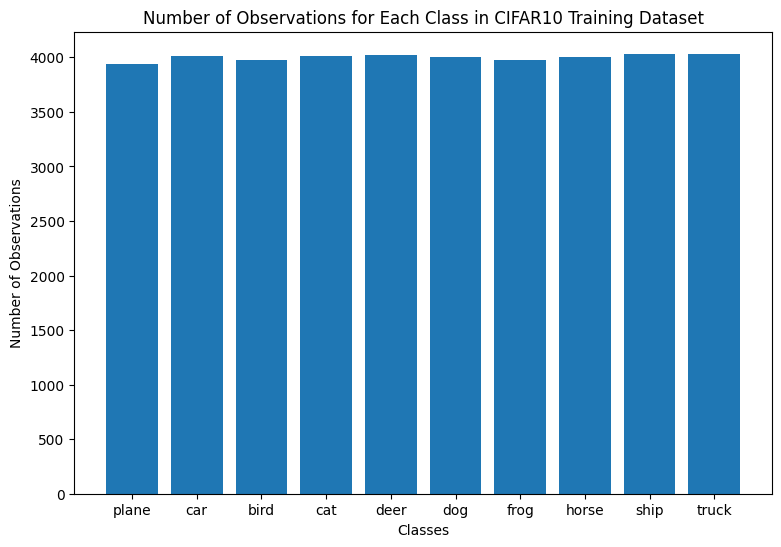

In [ ]:
# Observation per class in training data
plot_class_counts(train_loader)

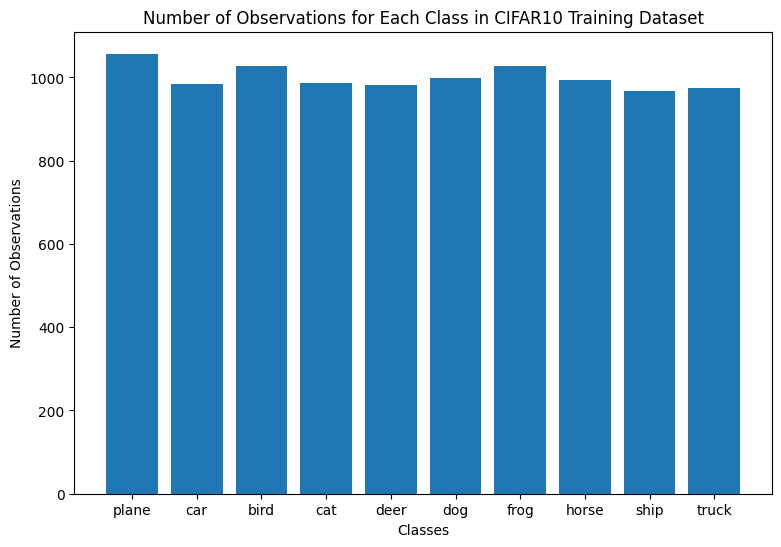

In [ ]:
# Observation per class in validation data
plot_class_counts(valid_loader)

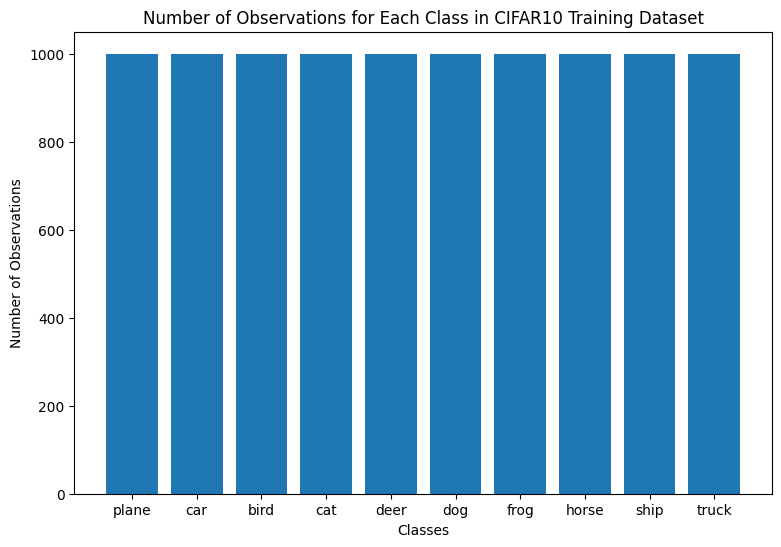

In [ ]:
# Observation per class in test data
plot_class_counts(test_loader)

**Analysis:**

From the all the three graphs present above, we find that the observations are distributed almost equally and there is no presence of bias, hence we can proceed forward for traiing.

<br/>

Lets now visulize the randomly the images of a batch

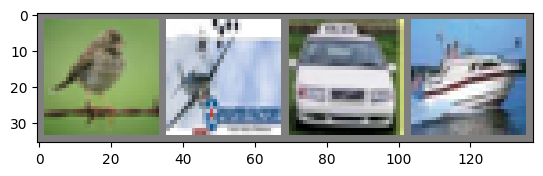

       bird         plane           car          ship


In [ ]:
def imshow(img):
    """
    Display an image.

    Args:
    - img (torch.Tensor): A tensor representation of the image.

    Returns:
    None
    """

    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()     # convert tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose dimensions for displaying
    plt.show()  # show the image

# get some random training images from the train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images using the imshow function
imshow(torchvision.utils.make_grid(images))

# print the labels corresponding to the displayed images
print('      ' + '         '.join('%5s' % cifar10_labels[labels[j]] for j in range(4)))


<br/>

### In-depth analysis of an Image

In this context, we examine the normalized red, green, and blue (RGB) channels as individual grayscale intensity visuals for demonstration. This approach aids in my subsequent discussion about CNNs.

Every small square visible represents pixels with their adjusted values. A higher value indicates more brightness, while a lower one signifies darkness. This depiction reflects how images are stored in computers. By merging the three channels, we obtain a colored picture. The RGB color model can depict approximately 16.77 million distinct colors, which is quite impressive.

You might have deduced by now that color images are inherently three-dimensional, in contrast to Greyscale images, which are 1D.

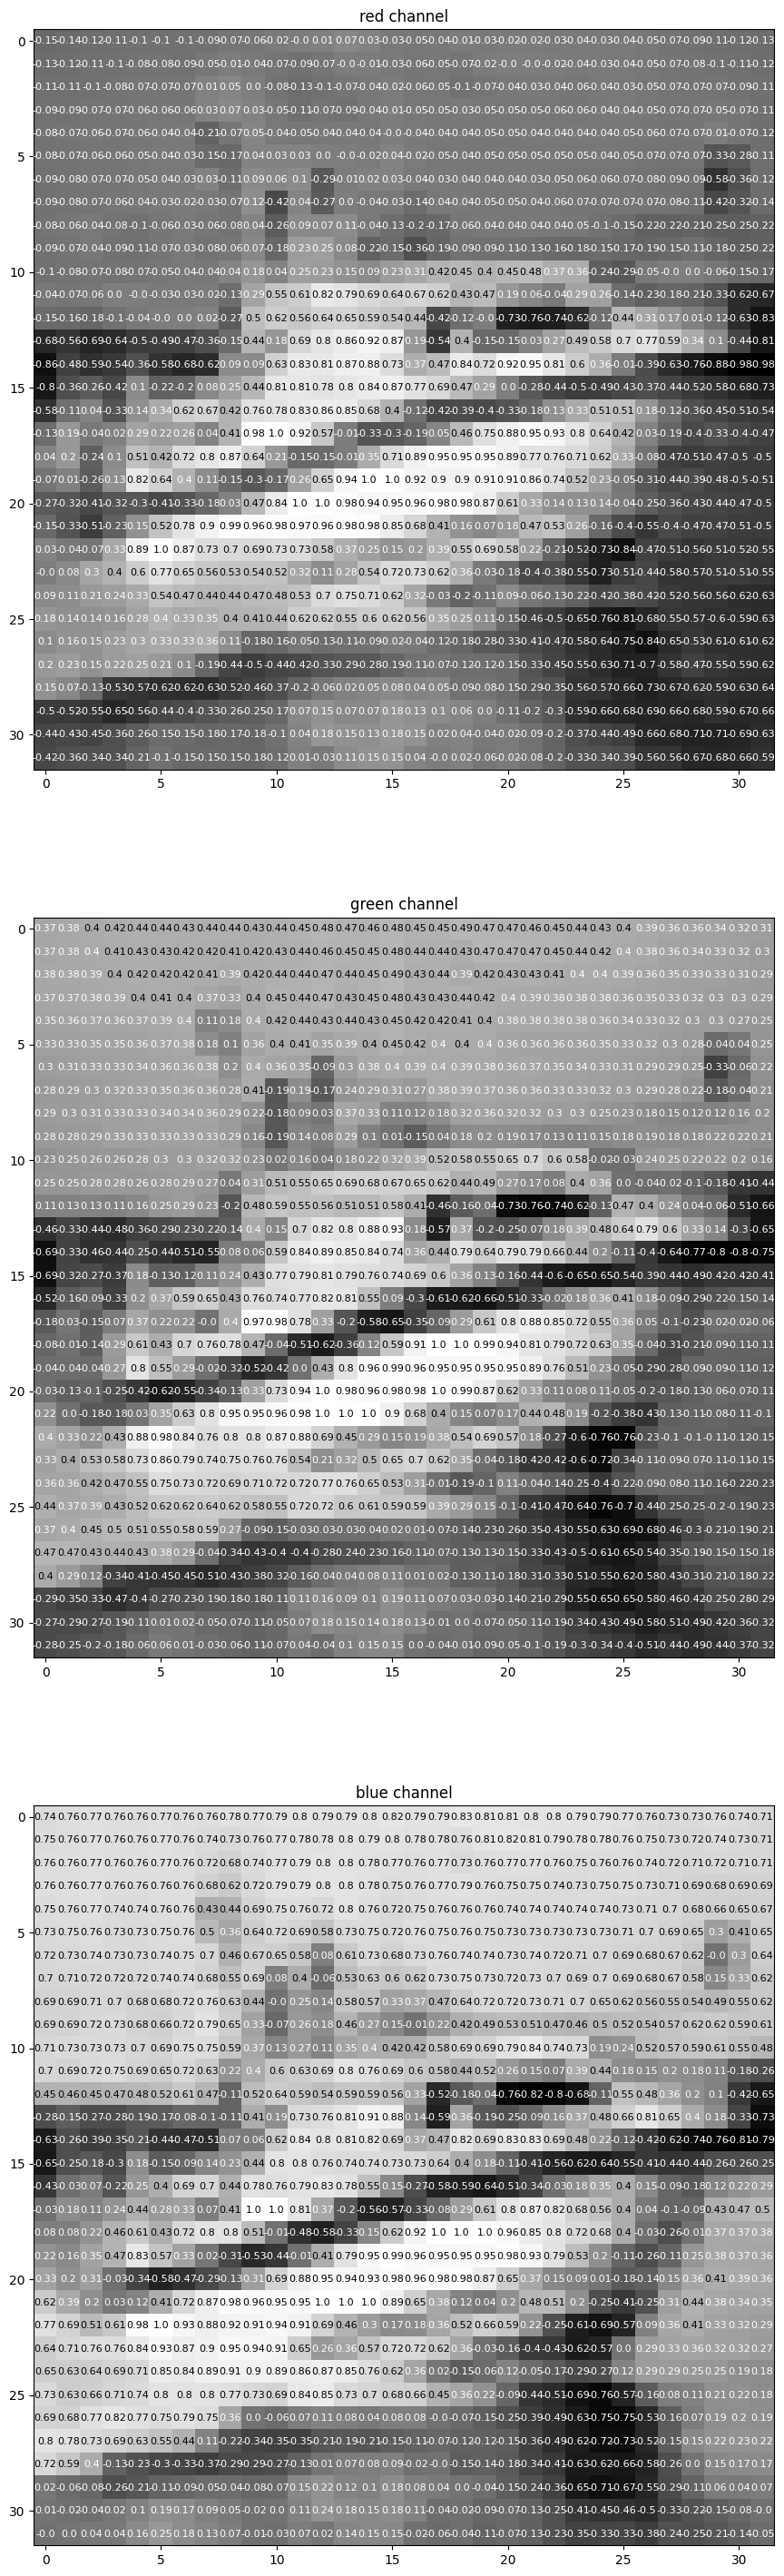

In [ ]:
def display_rgb_channels(img_tensor):
    """
    Display the RGB channels of an image with pixel values annotated.

    Args:
    - img_tensor (torch.Tensor): A tensor representation of the image.

    Returns:
    None
    """

    # Convert tensor to numpy array and remove any singleton dimensions
    rgb_img = np.squeeze(img_tensor.numpy())

    channels = ['red channel', 'green channel', 'blue channel']  # List of channel names

    # Create a figure with a specified size
    fig = plt.figure(figsize=(36, 36))

    # Loop through each channel (R, G, B)
    for idx in np.arange(rgb_img.shape[0]):

        # Create a subplot for the current channel
        ax = fig.add_subplot(3, 1, idx + 1)

        # Extract the individual channel data
        img = rgb_img[idx]

        # Display the channel data in grayscale (since it's 2D data)
        ax.imshow(img, cmap='gray')

        # Set the title for the current channel
        ax.set_title(channels[idx])

        width, height = img.shape  # Get the dimensions of the channel data
        thresh = img.max() / 2.5   # Threshold for font color decision

        # Annotate each pixel with its value
        for x in range(width):
            for y in range(height):
                val = round(img[x][y], 2) if img[x][y] != 0 else 0  # Round the pixel value to 2 decimal places
                ax.annotate(str(val), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center', size=8,
                            color='white' if img[x][y] < thresh else 'black')  # Set the font color based on the pixel value

    plt.show()  # Display the image

# Example usage:
display_rgb_channels(images[3])

The above output displayed is an image of a ship, which can be represented in the form of three primary colors - red, green and blue.

<br/>

## 3. Training Convolutional Nueral Networks

### Useful Functions

Below are a few functions designed to maximise code reusability

The provided code introduces a EarlyStopping class, which facilitates the early termination of training processes. This class is particularly useful to prevent overfitting when the validation loss does not show significant improvements over multiple epochs. The class keeps track of the best validation loss and if the loss does not improve beyond a threshold (delta) for a certain number of epochs (patience), it signals that training should be stopped.


In [20]:
class EarlyStopping:
    """Early Stopping to terminate training early under certain conditions.

    Early stopping is used to stop training a model when a monitored quantity
    (usually validation loss) stops improving. It aims to prevent overfitting
    and reduce computational waste.

    Attributes:
    - patience (int): Number of epochs to wait before stopping after the
                      validation loss has stopped decreasing.
    - delta (float): Minimum change in validation loss to qualify as an improvement.
    - counter (int): How many times the validation loss has not improved.
    - best_score (float or None): Best score achieved so far. Used to determine
                                 whether the validation loss has improved.
    - early_stop (bool): Whether or not to stop the training early.
    """

    def __init__(self, patience=5, delta=0):
        """
        Initializes the early stopping object.

        Args:
            patience (int): Number of epochs to wait before stopping after the
                           validation loss has stopped decreasing.
            delta (float): Minimum change in validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.early_stop = False

    def __call__(self, val_loss):
        """Evaluates if the validation loss has improved.

        Args:
            val_loss (float): Current validation loss.
        """
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

    def should_stop(self):
        """Returns if the early stopping criteria is met."""
        return self.early_stop

In [21]:
def initialize_device(net):
    """
    Sets the device for computation (either CUDA GPU or CPU) and moves the network to this device.

    Args:
    - net (torch.nn.Module): The neural network model.

    Returns:
    - device (torch.device): The device (CUDA GPU or CPU) on which computations will be performed.
    """

    # Check if CUDA is available, use CUDA (GPU) if available, otherwise use CPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Print the chosen device
    print(device)

    # Move the network to the chosen device
    net.to(device)

    # Print the device where the first convolutional layer's bias tensor is stored
    print(net.conv1.bias.get_device())

    return device

In [22]:
def train_model(net, tr_loader, vl_loader, device, optimizer, epoch_num=50):
    """
    Trains the provided neural network model using training data and evaluates it using validation data.
    Implements early stopping based on the validation loss.

    Args:
    - net (torch.nn.Module): The neural network model to be trained.
    - tr_loader (torch.utils.data.DataLoader): DataLoader for the training set.
    - vl_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
    - device (torch.device): Device (either CPU or CUDA) where tensors are moved for computation.
    - optimizer (torch.optim.Optimizer): Optimizer used for model training.
    - epoch_num (int, optional): Total number of training epochs. Defaults to 50.

    Returns:
    - history (dict): A record of training and validation metrics across epochs.
    """

    # Initialize early stopping mechanism. Stops if validation loss doesn't improve by 'delta'
    # over 'patience' consecutive epochs.
    early_stopping = EarlyStopping(patience=5, delta=0.01)

    # Lists for recording epoch-wise metrics.
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    # Begin the training loop over epochs.
    for epoch in range(epoch_num):
        running_loss, correct, total = 0.0, 0, 0

        # Switch model to training mode. This is necessary because some layers like Dropout or BatchNorm
        # have different behavior during training and evaluation.
        net.train()

        # Iterating over batches of training data.
        for i, data in enumerate(tr_loader, 0):
            # Retrieve inputs and labels, and transfer them to the specified device.
            inputs, labels = data[0].to(device), data[1].to(device)

            # Reset gradients accumulated in the optimizer.
            optimizer.zero_grad()

            # Compute model predictions.
            outputs = net(inputs)
            # Compute loss between predictions and ground truth labels.
            loss = criterion(outputs, labels)

            # Backpropagate errors & adjust model parameters.
            loss.backward()
            optimizer.step()

            # Compute number of correct predictions to determine accuracy.
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Aggregate loss for this batch.
            running_loss += loss.item()

        # Record and print training metrics for the current epoch.
        train_losses.append(running_loss/len(tr_loader))
        train_accuracies.append(100 * correct / total)
        print(f'Epoch {epoch+1}\nTraining Loss: {running_loss/len(tr_loader):.3f}\nTraining Accuracy: {100 * correct / total:.2f}%')

        # Validation phase: model is set to evaluation mode.
        net.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        # Disable gradient calculations as they're not needed during validation, reducing memory usage.
        with torch.no_grad():
            for data in vl_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_loss += loss.item()

        # Record and print validation metrics for the current epoch.
        val_losses.append(val_loss/len(vl_loader))
        val_accuracies.append(100 * val_correct / val_total)
        print(f'Validation Loss: {val_loss/len(vl_loader):.3f}\nValidation Accuracy: {100 * val_correct / val_total:.2f}%\n')

        # Check for early stopping. Breaks out of loop if early stop conditions are met.
        early_stopping(val_loss/len(vl_loader))
        if early_stopping.should_stop():
            print("Early stopping triggered after epoch:", epoch+1)
            break

    # Compile all metrics into a history dictionary for further analysis or plotting.
    history = {
        "train_loss": train_losses,
        "train_accuracy": train_accuracies,
        "val_loss": val_losses,
        "val_accuracy": val_accuracies
    }

    print('Finished Training')
    return history

In [23]:
def plot_training_history(history):
    """
    Plots the training history of a model.

    Args:
    - history (dict): Dictionary containing training and validation losses and accuracies.

    Returns:
    None
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [37]:
def save_path(network):
    """
    Saves the state dictionary of the given PyTorch neural network model to a path.

    Args:
    - network (torch.nn.Module): The neural network model whose state dictionary is to be saved.

    Returns:
    - str: The path where the model's state dictionary has been saved.

    Note:
    Only the model's state dictionary is saved, not the entire model architecture.
    """

    # Path to save the model's state dictionary with '.pth' extension.
    PATH = './cifar_net.pth'

    # Save the model's state dictionary to the specified path.
    torch.save(network.state_dict(), PATH)

    return PATH

In [66]:
def show_random_images():
    """
    Display a random set of images from the test dataset along with their labels.

    Returns:
    - images (torch.Tensor): The randomly selected batch of images.
    """

    # Fetch a random batch of images and labels from the test dataset
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Display the images in a grid format
    imshow(torchvision.utils.make_grid(images))

    # Print the class labels for the displayed images
    print('      ' + '         '.join('%5s' % cifar10_labels[labels[j]] for j in range(4)))

    return images

In [49]:
def get_predictions(net, img):
    """
    Get the predictions from the optimized network for the given images.

    Args:
    - net: The optimized network.
    - images: The images you want to get predictions for.
    """

    # Forward pass: Get the predictions from the optimized network for the given images
    outputs = net(img)

    # Get the indices of the maximum values in the outputs.
    # These indices correspond to the predicted classes for each image.
    _, predicted = torch.max(outputs, 1)

    # Print the predicted classes using their corresponding labels from the CIFAR-10 dataset.
    # Display labels for the first 4 images.
    print('Predicted: ', '  '.join('%5s' % cifar10_labels[predicted[j]]
                                  for j in range(4)))

In [27]:
def evaluate_test_accuracy(net):
    """
    Evaluate the accuracy of the provided neural network model on the test dataset.

    Args:
    - net (torch.nn.Module): The trained neural network model to be evaluated.

    Returns:
    - accuracy (float): The computed accuracy of the model on the test dataset.
    """

    # Initialize counters for correct predictions and the total number of samples.
    correct = 0
    total = 0

    # Ensure no gradients are computed since we're only evaluating, which saves memory and computation.
    with torch.no_grad():
        # Loop over each batch in the test dataset.
        for data in test_loader:
            # Extract images and corresponding labels from the current batch.
            images, labels = data

            # Compute the model's predictions for the current batch.
            outputs = net(images)

            # Get the predicted class label (index with the highest score) for each image in the batch.
            _, predicted = torch.max(outputs.data, 1)

            # Update the total number of images processed so far.
            total += labels.size(0)

            # Update the number of correctly predicted images.
            correct += (predicted == labels).sum().item()

    # Calculate the accuracy of the model on the test dataset.
    accuracy = 100 * correct / total

    # Display the computed accuracy.
    print('Accuracy of the network on the 10000 test images: %d %%' % (accuracy))

    return accuracy

In [ ]:
def evaluate_individual_class_accuracies(net):
    # Create lists to store correct predictions and total predictions for each of the 10 classes
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    # Disabling gradient computation as we are only evaluating the model (not training)
    with torch.no_grad():
        # Loop through each batch of test data
        for data in test_loader:
            # Separate the images and their true labels from the data
            images, labels = data
            # Get model predictions for the batch of images
            outputs = net(images)
            # Get the index (class) of the highest prediction probability for each image
            _, predicted = torch.max(outputs, 1)
            # Compare predicted labels with true labels
            c = (predicted == labels).squeeze()
            # Loop through each image in the batch
            for i in range(4):
                # Get the true label for the current image
                label = labels[i]
                # Update the correct prediction count for the class of the current image
                class_correct[label] += c[i].item()
                # Update the total prediction count for the class of the current image
                class_total[label] += 1

    # Loop through each of the 10 classes
    for i in range(10):
        # Print the accuracy for each class
        print('Accuracy of %5s : %2d %%' % (
            cifar10_labels[i], 100 * class_correct[i] / class_total[i]))

In [64]:
# data frame to store CNN network performances
network_performances = pd.DataFrame(columns = ['cnn_network', 'data_augmentation', 'test_accuracy'])



<br/>

### **Network - 1**
#### Without Data Augmentation

The CNN_Network_1 is a convolutional neural network defined using the PyTorch framework. Here's a breakdown of its structure and components:

<br/>

1. Convolutional Layer (conv1):
* Input: 3 channels (typically representing RGB channels of an image).
* Output: 16 feature maps.
  Kernel Size: 5x5, meaning each filter in this layer is of size 5x5.

<br/>

2. Max Pooling Layer (pool):
* Uses a 2x2 window for down-sampling the feature maps.
* The stride is set to 2, indicating the window moves 2 pixels at a time, reducing the spatial dimensions by half.

<br/>

3. Fully Connected Layer (fc1):
* After the pooling operation, the feature map dimensions are reduced to 14x14 with 16 channels. These are flattened to form a single vector of size 16*14*14.
* This layer reduces the dimensionality of the input to produce 10 output units, which can be useful for a 10-class classification problem.

The forward method describes the sequence of operations applied to the input tensor x. The tensor first passes through the convolutional layer, followed by the ReLU activation function, then max pooling. The tensor is then flattened and passed through the fully connected layer to produce the final output.


In [29]:
class CNN_Network_1(nn.Module):
    def __init__(self):
        super(CNN_Network_1, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5)      # Convolutional layer
        self.pool = nn.MaxPool2d(2, 2)        # Max pooling layer
        self.fc1 = nn.Linear(16 * 14 * 14, 10) # Fully connected layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution -> ReLU -> Pooling
        x = x.view(-1, 16 * 14 * 14)          # Flatten tensor
        x = self.fc1(x)                       # Apply fully connected layer
        return x

network_1 = CNN_Network_1()                  # Create a network instance
print(network_1)                            # Print network architecture

CNN_Network_1(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=10, bias=True)
)


In [30]:
# Initialize the device (CUDA or CPU)
net_1_device = initialize_device(network_1)

cpu
-1


In [31]:
# Define the loss function for the neural network. CrossEntropyLoss combines LogSoftmax and NLLLoss.
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the 'network_1' network. Using Stochastic Gradient Descent (SGD) with a learning rate of 0.001
optimizer_net_1 = optim.SGD(network_1.parameters(), lr=0.001)

In [32]:
# Train the CNN with optimised parameters
net_1_history = train_model(network_1, train_loader, valid_loader, net_1_device, optimizer_net_1)

Epoch 1
Training Loss: 1.739
Training Accuracy: 38.95%
Validation Loss: 1.548
Validation Accuracy: 46.24%

Epoch 2
Training Loss: 1.437
Training Accuracy: 49.52%
Validation Loss: 1.398
Validation Accuracy: 51.13%

Epoch 3
Training Loss: 1.332
Training Accuracy: 53.27%
Validation Loss: 1.313
Validation Accuracy: 54.03%

Epoch 4
Training Loss: 1.262
Training Accuracy: 56.06%
Validation Loss: 1.268
Validation Accuracy: 56.21%

Epoch 5
Training Loss: 1.199
Training Accuracy: 58.55%
Validation Loss: 1.221
Validation Accuracy: 57.36%

Epoch 6
Training Loss: 1.143
Training Accuracy: 60.71%
Validation Loss: 1.176
Validation Accuracy: 59.05%

Epoch 7
Training Loss: 1.095
Training Accuracy: 62.37%
Validation Loss: 1.149
Validation Accuracy: 59.94%

Epoch 8
Training Loss: 1.058
Training Accuracy: 63.48%
Validation Loss: 1.119
Validation Accuracy: 60.92%

Epoch 9
Training Loss: 1.029
Training Accuracy: 64.69%
Validation Loss: 1.104
Validation Accuracy: 61.51%

Epoch 10
Training Loss: 1.006
Trainin

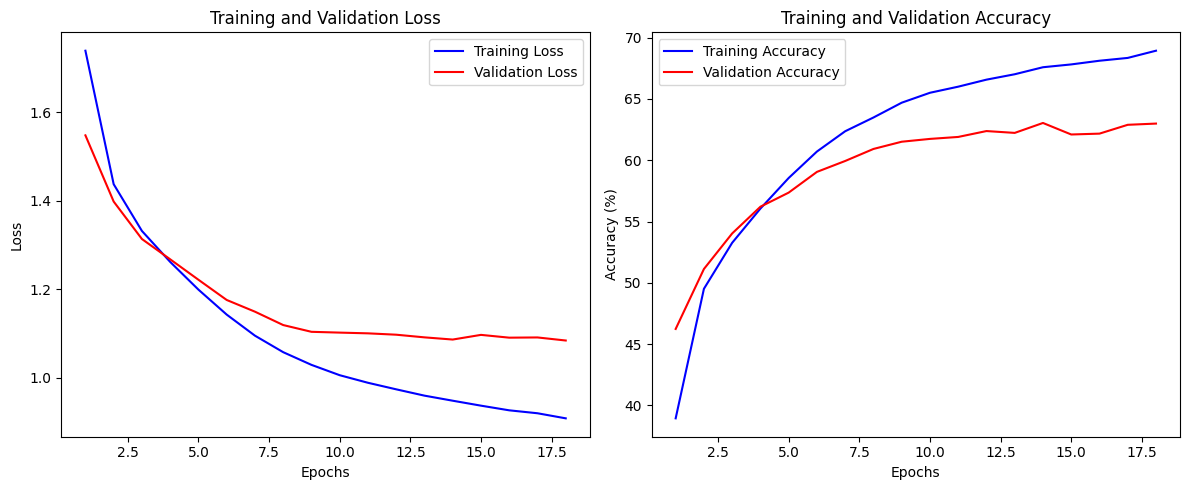

In [33]:
# Plot the training history
plot_training_history(net_1_history)

**Analysis:**

**Training and Validation Loss**
1. The training loss decreases consistently throughout the epochs, suggesting that the model is learning and adjusting its weights effectively.
2. The validation loss also decreases initially but starts to plateau around epoch 15. This indicates that the model might be beginning to overfit the training data after this point, as it's no longer showing significant improvement on the unseen validation data.

**Training and Validation Accuracy**
1. Training accuracy shows a steady increase, reaching close to 70% by epoch 18. This again confirms that the model is learning from the training dataset.
2. The validation accuracy, on the other hand, rises sharply in the first few epochs but begins to level off around 55% accuracy after epoch 10. Post this, it remains relatively stable with slight fluctuations.

**Overall Analysis:**
- The model demonstrates clear learning, as evidenced by the decrease in training loss and increase in training accuracy.
- The validation results suggest that the model may start to overfit the training data after approximately 15 epochs since the validation accuracy plateaus and the validation loss starts stabilizing.
- The early stopping at epoch 18 seems appropriate given that further training might lead to more pronounced overfitting without substantial improvement in validation performance.

Recommendation:
- It might be beneficial to employ regularization techniques or further tune hyperparameters to see if the gap between training and validation performance can be reduced. This can help in achieving a more generalized model.

In [53]:
# Save the network path
net1_PATH = save_path(network_1)

#### Performance on Test Data

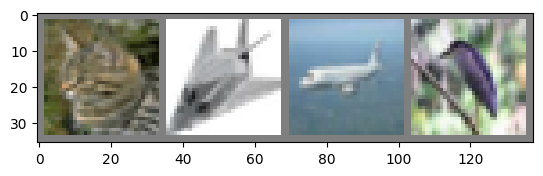

        cat         plane         plane          bird


In [58]:
# Randomly obtained images from test set
net1_img = show_random_images()

In [61]:
# Instantiate the Enhanced_CNN_Net model
net = CNN_Network_1()

# Load the pre-trained weights and biases from the specified path into the model
net.load_state_dict(torch.load(net1_PATH))

<All keys matched successfully>

In [62]:
# Obtain predictions
get_predictions(net, net1_img)

Predicted:   frog  plane  plane    cat


**Analysis:**

The second and third images were identified correctly but the first and fourth images were not identified correctly

In [63]:
# Evaluate test accuracy
accuracy = evaluate_test_accuracy(net)

Accuracy of the network on the 10000 test images: 63 %


In [65]:
# Append the model information to the dataframe
network_performances.loc[len(network_performances)] = ["Network 1", False, accuracy]



<br/>

### **Network - 1**
#### with Data Augmentation

The code snippet initializes an instance of the `CNN_Network_1` class, which represents a specific convolutional neural network architecture. While this instance, named `network_1_aug`, uses the same architectural layout as the previously mentioned `network_1`, it's intended for use with a dataset that has undergone data augmentation. Specifically, the data provided to this network is augmented with methods like `transforms.RandomRotation(10)` and `transforms.RandomHorizontalFlip()`. These augmentations introduce random rotations of up to 10 degrees and random horizontal flips, respectively. Such techniques can help the model generalize better by exposing it to diverse variations of the input data.

In [68]:
# Instantiate a new instance of the CNN_Network_1 class
network_1_aug = CNN_Network_1()

# Print the architecture (layers and their configurations) of the created network
print(network_1_aug)

CNN_Network_1(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=10, bias=True)
)


In [70]:
#Initialize the device (CUDA or CPU)
net_1_device_aug = initialize_device(network_1_aug)

cpu
-1


In [71]:
# Define the loss function for the neural network. CrossEntropyLoss combines LogSoftmax and NLLLoss.
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the 'cnn_net' network. Using Stochastic Gradient Descent (SGD) with a learning rate of 0.001
optimizer_net_1_aug = optim.SGD(network_1_aug.parameters(), lr=0.001)

In [72]:
# Train the CNN with optimised parameters
net_1_aug_history = train_model(network_1_aug, train_loader_augmented, valid_loader_augmented, net_1_device_aug, optimizer_net_1_aug)

Epoch 1
Training Loss: 1.784
Training Accuracy: 37.28%
Validation Loss: 1.558
Validation Accuracy: 46.25%

Epoch 2
Training Loss: 1.465
Training Accuracy: 48.49%
Validation Loss: 1.395
Validation Accuracy: 51.68%

Epoch 3
Training Loss: 1.375
Training Accuracy: 51.99%
Validation Loss: 1.347
Validation Accuracy: 53.22%

Epoch 4
Training Loss: 1.333
Training Accuracy: 53.21%
Validation Loss: 1.304
Validation Accuracy: 54.14%

Epoch 5
Training Loss: 1.302
Training Accuracy: 54.31%
Validation Loss: 1.281
Validation Accuracy: 55.37%

Epoch 6
Training Loss: 1.270
Training Accuracy: 55.43%
Validation Loss: 1.251
Validation Accuracy: 56.29%

Epoch 7
Training Loss: 1.246
Training Accuracy: 56.48%
Validation Loss: 1.239
Validation Accuracy: 57.22%

Epoch 8
Training Loss: 1.216
Training Accuracy: 57.62%
Validation Loss: 1.227
Validation Accuracy: 56.90%

Epoch 9
Training Loss: 1.195
Training Accuracy: 58.29%
Validation Loss: 1.194
Validation Accuracy: 58.34%

Epoch 10
Training Loss: 1.176
Trainin

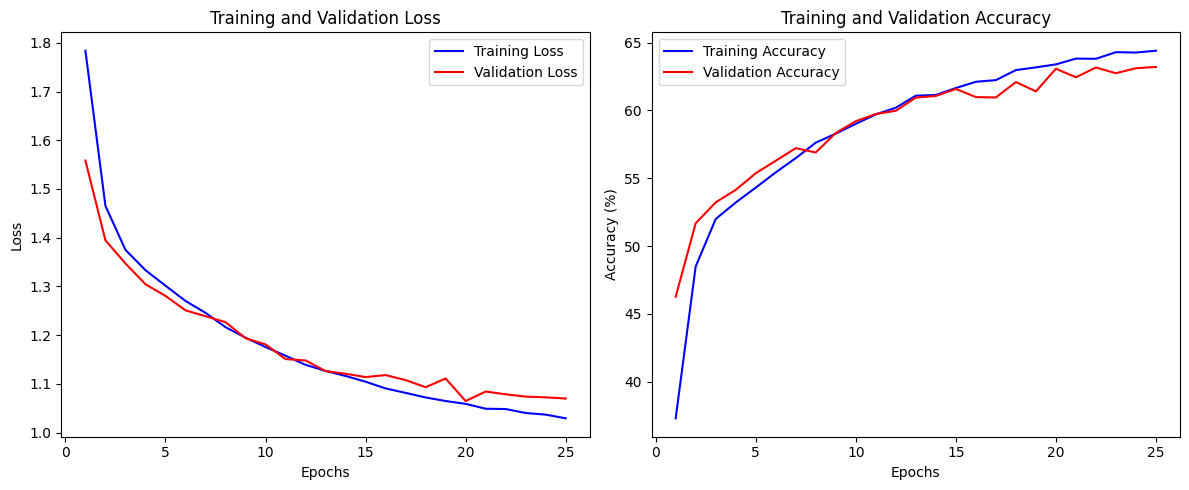

In [73]:
# Plot the training history
plot_training_history(net_1_aug_history)

**Analysis:**

1. **Loss Analysis**:
   - **Training Loss**: The training loss starts at a value around 1.8 and steadily declines over 25 epochs. This indicates that the network is learning and improving its predictions for the training set.
   - **Validation Loss**: The validation loss also begins at a higher value and reduces over time, closely following the trend of the training loss. However, it's worth noting that around 20 epochs, the validation loss seems to stabilize and may be showing signs of a slight increase. This could be an early indication of overfitting, where the model might start to perform well on the training data but not as well on the unseen validation data.

2. **Accuracy Analysis**:
   - **Training Accuracy**: The training accuracy starts at around 40% and sees a substantial increase, approaching roughly 65% by the 25th epoch. This shows that the model is increasingly classifying the training samples correctly.
   - **Validation Accuracy**: The validation accuracy curve closely follows the training accuracy curve but remains consistently below it. This is typical as models generally perform better on training data compared to unseen data. By the 25th epoch, the validation accuracy is slightly above 60%. The gap between training and validation accuracy is not too wide, but it still suggests some degree of overfitting but overfitting is reduced significantly compared to previous network.
   
3. **Early Stopping Consideration**:
   - The graphs suggest that the model's performance on the validation set is stabilizing around the 20th epoch. Especially in the validation loss graph, there's an indication that the model might start to overfit after this point as the loss appears to plateau and might start increasing.
   - Implementing early stopping around the 20th epoch might be beneficial as it can prevent potential overfitting, save computational resources, and potentially provide a model that generalizes better to unseen data.

4. **General Observations**:
   - The model has a reasonable performance given that the accuracy on the validation set is above 60% by the 25th epoch.
   - The trends in both loss and accuracy graphs are consistent, further validating the observed behaviors.
   - There's room for improvement, and further tuning, regularization techniques, or data augmentation might help in boosting the model's performance and generalization capabilities.


**Main point: Overfitting is reduced significantly for this network compared to the previous network**

In [74]:
# Save the path
net1_PATH_aug = save_path(network_1_aug)

#### Performance on Test Data

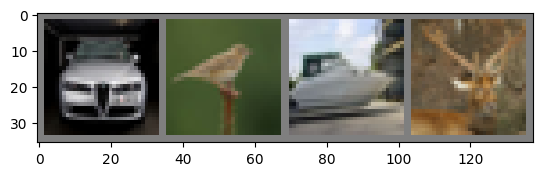

        car          bird          ship          deer


In [75]:
# Select random images from test set
net1_img_aug = show_random_images()

In [76]:
# Instantiate the Enhanced_CNN_Net model
net = CNN_Network_1()

# Load the pre-trained weights and biases from the specified path into the model
net.load_state_dict(torch.load(net1_PATH_aug))

<All keys matched successfully>

In [77]:
# Obtain predictions for the above random images
get_predictions(net, net1_img_aug)

Predicted:    car   bird    car   deer


**Analysis:**

Three out of the four images were correctly identified by the network. The third image is actually ship on the road, but the network predicted it to be a car

In [78]:
# Evaluate test accuracy for the network
accuracy = evaluate_test_accuracy(net)

Accuracy of the network on the 10000 test images: 64 %


In [79]:
# Append the model information to the dataframe
network_performances.loc[len(network_performances)] = ["Network 1", True, accuracy]



<br/>

### **Network - 2**

The CNN_Network_2 class represents a slightly enhanced convolutional neural network architecture compared to the previously discussed CNN_Network_1.

<br/>

1. Convolutional Layers:
* The first layer (conv1) maps input images with 3 channels (RGB) to 16 feature maps using 3x3 filters. Padding is added to ensure the spatial dimensions remain consistent.
* The second layer (conv2) takes the 16 feature maps from the previous layer and produces 32 feature maps, also using 3x3 filters with padding.

<br/>

2. Batch Normalization:
After each convolutional layer, a batch normalization layer is applied. This can help in stabilizing and accelerating the learning process.

<br/>

3. Dropout Layer:
A dropout layer is introduced before the fully connected layer. This helps in preventing overfitting by randomly setting a fraction (30% in this case) of input units to 0 during training.

<br/>

4. Pooling and Activation:
ReLU activation functions are applied after each batch normalization layer.
Max pooling operations (with 2x2 window size) are used after each ReLU activation to reduce spatial dimensions by half.

<br/>

5. Fully Connected Layer:
After the convolutional layers, the tensor is flattened and passed through a fully connected layer to produce a 10-dimensional output, which can be interpreted as scores for 10 classes.

<br/>

**Comparison with Network 1:**

1. Additional Convolutional Layer: CNN_Network_2 has an extra convolutional layer (conv2) which can help in capturing more complex features.
2. Batch Normalization: The new architecture includes batch normalization layers that were absent in CNN_Network_1. These can help in improving training efficiency.
3. Dropout: CNN_Network_2 introduces dropout before the fully connected layer, which was missing in CNN_Network_1. This can aid in reducing overfitting.
4. Filter Sizes and Padding: In CNN_Network_1, the convolutional layer used 5x5 filters without padding. In contrast, CNN_Network_2 uses 3x3 filters with padding, which can help in preserving spatial dimensions.
5. Depth: The depth (or number of feature maps) at the end of the convolutional layers is higher in CNN_Network_2 (32) than in CNN_Network_1 (16). This can allow the new network to capture more detailed features.

In [80]:
class CNN_Network_2(nn.Module):
    def __init__(self):
        super(CNN_Network_2, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        # Batch normalization layer after first convolution
        self.bn1 = nn.BatchNorm2d(16)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        # Batch normalization layer after second convolution
        self.bn2 = nn.BatchNorm2d(32)

        # Dropout layer with 30% dropout rate
        self.dropout = nn.Dropout(0.3)

        # Fully connected layer
        self.fc1 = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        # First convolution -> Batch Normalization -> ReLU -> Max Pooling
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)

        # Second convolution -> Batch Normalization -> ReLU -> Max Pooling
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)

        # Flatten -> Dropout -> Fully connected layer
        x = x.view(-1, 32 * 8 * 8)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

network_2 = CNN_Network_2()
print(network_2)

CNN_Network_2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)


In [81]:
#Initialize the device (CUDA or CPU)
net_2_device = initialize_device(network_2)

cpu
-1


In [82]:
# Define the loss function for the neural network. CrossEntropyLoss combines LogSoftmax and NLLLoss.
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the 'cnn_net' network. Using Stochastic Gradient Descent (SGD) with a learning rate of 0.001
optimizer_net_2 = optim.SGD(network_2.parameters(), lr=0.001)

In [83]:
# Train the CNN with optimised parameters
net_2_history = train_model(network_2, train_loader_augmented, valid_loader_augmented, net_2_device, optimizer_net_2)

Epoch 1
Training Loss: 1.621
Training Accuracy: 42.55%
Validation Loss: 1.269
Validation Accuracy: 55.86%

Epoch 2
Training Loss: 1.365
Training Accuracy: 51.99%
Validation Loss: 1.199
Validation Accuracy: 58.43%

Epoch 3
Training Loss: 1.279
Training Accuracy: 55.00%
Validation Loss: 1.150
Validation Accuracy: 60.14%

Epoch 4
Training Loss: 1.220
Training Accuracy: 57.44%
Validation Loss: 1.101
Validation Accuracy: 61.48%

Epoch 5
Training Loss: 1.172
Training Accuracy: 59.25%
Validation Loss: 1.043
Validation Accuracy: 64.28%

Epoch 6
Training Loss: 1.143
Training Accuracy: 59.94%
Validation Loss: 1.060
Validation Accuracy: 62.96%

Epoch 7
Training Loss: 1.115
Training Accuracy: 61.13%
Validation Loss: 1.005
Validation Accuracy: 65.69%

Epoch 8
Training Loss: 1.098
Training Accuracy: 61.70%
Validation Loss: 0.989
Validation Accuracy: 65.90%

Epoch 9
Training Loss: 1.079
Training Accuracy: 62.59%
Validation Loss: 0.981
Validation Accuracy: 67.08%

Epoch 10
Training Loss: 1.057
Trainin

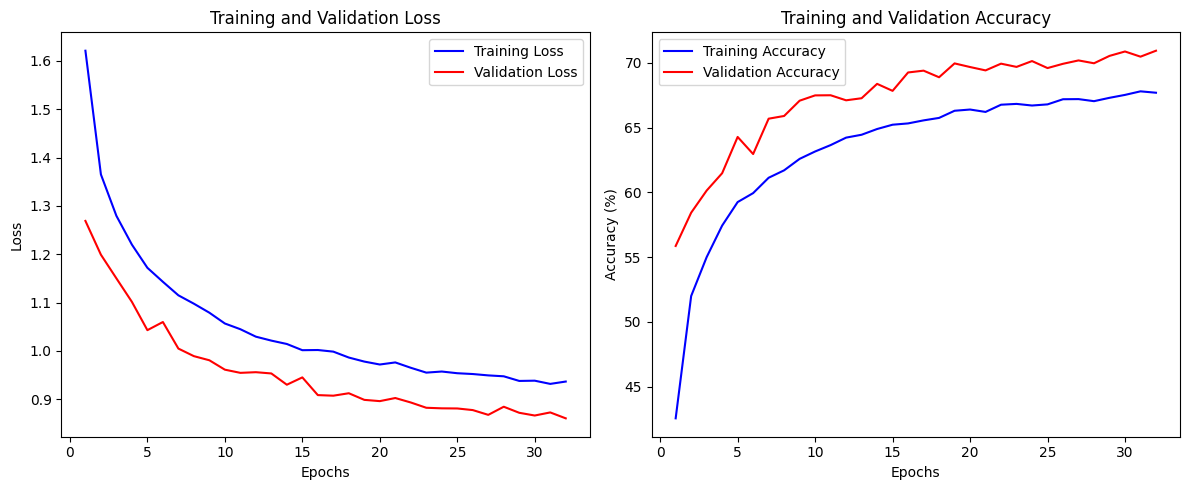

In [84]:
# Plot the training history
plot_training_history(net_2_history)

**Analysis:**

Based on the provided plots for the performance of the CNN network, here's an analysis:

1. **Training & Validation Loss**:
    - The training loss (in blue) shows a steady decrease, which suggests that the model is learning and improving its performance on the training set over the epochs.
    - The validation loss (in red) also starts decreasing initially but seems to stabilize and slightly increase after around 20 epochs. This can be an early sign of overfitting, where the model is becoming too specialized for the training data and not generalizing well to unseen data (validation set).
  
2. **Training & Validation Accuracy**:
    - The training accuracy (in blue) increases steadily, which is expected as the loss decreases.
    - The validation accuracy (in red) also increases initially but starts to plateau after around 20 epochs. This plateau, combined with the stabilization in the validation loss, suggests that further training might not lead to significant improvements in the model's performance on the validation set.
  
3. **Early Stopping**:
    - Early stopping occurred at epoch 32. Given the plots, this decision seems justified. Post the 20th epoch, there's minimal gain in validation accuracy, and the validation loss starts to stabilize (with a slight increase). Hence, continuing training might only make the model memorize the training data without improving its generalization capability.

**Conclusions**:

- The model trains well and learns patterns in the initial epochs, as indicated by the steady decrease in training loss and increase in training accuracy.
- The model starts to show signs of overfitting after the 20th epoch, as the validation accuracy plateaus and the validation loss begins to stabilize/increase.
- The implementation of early stopping at epoch 32 is a good strategy to prevent the model from overfitting further.

Future Recommendations:

- To further improve performance, techniques like data augmentation, different regularization methods, or architectural tweaks can be explored.

In [96]:
# Save the path
net2_PATH = save_path(network_2)

#### Performance on Test Data

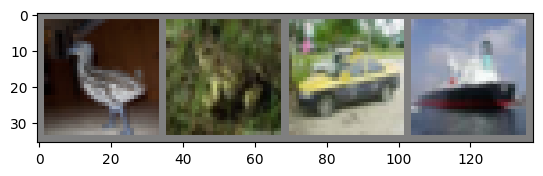

       bird          frog           car          ship


In [87]:
# Select random images from test set
net2_img = show_random_images()

In [88]:
# Instantiate the Enhanced_CNN_Net model
net = CNN_Network_2()

# Load the pre-trained weights and biases from the specified path into the model
net.load_state_dict(torch.load(net2_PATH))

<All keys matched successfully>

In [89]:
# Obtain predictions for the above random images
get_predictions(net, net2_img)

Predicted:    cat   frog    car   ship


**Analysis:**

The network predicted three out of four images correctly and misclassified an image of a bird as cat

In [90]:
# Evaluate test accuracy for the network
accuracy = evaluate_test_accuracy(net)

Accuracy of the network on the 10000 test images: 67 %


In [91]:
# Append the model information to the dataframe
network_performances.loc[len(network_performances)] = ["Network 2", True, accuracy]



<br/>

### **Network - 3**

<br/>

1. Convolutional Layers:
The model has three convolutional layers (conv1, conv2, and conv3). Each layer applies a 3x3 convolutional kernel. The depths for the layers are 32, 64, and 128 respectively. Padding is set to 1 to keep the spatial dimensions consistent.

<br/>

2. Batch Normalization: Batch normalization layers (bn1, bn2, and bn3) are used after each convolutional layer. They normalize the activations of the neurons, which can help in speeding up the learning process and providing some regularization effect.

<br/>

3. Pooling Layers: After each convolutional layer, max pooling with a 2x2 kernel is applied. This reduces the spatial dimensions by half, thus reducing the computational load for the subsequent layers and also helping in capturing the most prominent features.

<br/>

4. Fully Connected Layers:
* The model has two fully connected layers (fc1 and fc2). The first layer (fc1) maps the flattened output of the last convolutional layer to 1024 neurons.
* There's a dropout layer with a probability of 0.3 between the fully connected layers to prevent overfitting.
* The final layer (fc2) maps the 1024 neurons to 10 output neurons. These 10 neurons could correspond to 10 different classes, indicating a classification task with 10 categories.

<br/>

5. Activation Functions: The ReLU activation function is applied after every convolutional and the first fully connected layer, which adds non-linearity to the model, allowing it to learn complex patterns.

<br/>

**Comparision with Network - 2**

Increased Depth: CNN_Network_3 has an additional convolution layer, which can capture more complex and hierarchical features from the input.

1. Batch Normalization: CNN_Network_3 uses Batch Normalization after each convolution layer. This can help in faster and more stable training by reducing internal covariate shift.

2. Increased Channel Capacity: The channel progression in CNN_Network_3 (3 -> 32 -> 64 -> 128) is denser compared to CNN_Network_2. This means CNN_Network_3 has the potential to learn more features at each layer.

3. Dropout: The inclusion of a Dropout layer in CNN_Network_3 helps prevent overfitting, especially when the network becomes deeper or the dataset is limited.

4. Larger Fully Connected Layer: CNN_Network_3 has a larger first fully connected layer with 1024 neurons compared to the 128 neurons in CNN_Network_2. This can provide more capacity for the network to learn complex mappings.

CNN_Network_3 has architectural components that can potentially lead to improved feature extraction and better generalization on unseen data compared to CNN_Network_2.

In [92]:
# Define the convolutional neural network architecture
class CNN_Network_3(nn.Module):
    def __init__(self):
        super(CNN_Network_3, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for first conv layer

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for second conv layer

        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization for third conv layer

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)  # First fully connected layer
        self.dropout = nn.Dropout(0.3)  # Dropout layer to prevent overfitting
        self.fc2 = nn.Linear(1024, 10)  # Second fully connected layer (output layer)

    def forward(self, x):
        # Passing through the first convolutional layer
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)

        # Passing through the second convolutional layer
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)

        # Passing through the third convolutional layer
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)

        # Flattening the tensor
        x = x.view(-1, 128 * 4 * 4)

        # Passing through the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Creating an instance of the CNN and printing its architecture
network_3 = CNN_Network_3()
print(network_3)

CNN_Network_3(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


In [93]:
# Initialize the device (CUDA or CPU)
net_3_device = initialize_device(network_3)

cpu
-1


In the below code, a loss function (criterion) is defined using the CrossEntropyLoss which is commonly used for multi-class classification problems. Additionally, an optimizer (optimizer_enh) is defined using Stochastic Gradient Descent (SGD) for the enh_net neural network with a specified learning rate and momentum.

In [94]:
# Define the loss function for the neural network. CrossEntropyLoss combines LogSoftmax and NLLLoss.
criterion = nn.CrossEntropyLoss()

# Define the optimizer for the 'enh_net' network. Using Stochastic Gradient Descent (SGD) with a learning rate of 0.0001
# and a momentum of 0.9 to accelerate convergence.
optimizer_net_3 = optim.SGD(network_3.parameters(), lr=0.0001, momentum=0.9)

In [95]:
# Train the CNN with optimised parameters
net_3_history = train_model(network_3, train_loader_augmented, valid_loader_augmented, net_3_device, optimizer_net_3)

Epoch 1
Training Loss: 1.568
Training Accuracy: 43.84%
Validation Loss: 1.217
Validation Accuracy: 57.01%

Epoch 2
Training Loss: 1.208
Training Accuracy: 57.29%
Validation Loss: 1.069
Validation Accuracy: 62.16%

Epoch 3
Training Loss: 1.071
Training Accuracy: 61.95%
Validation Loss: 0.977
Validation Accuracy: 65.97%

Epoch 4
Training Loss: 0.984
Training Accuracy: 65.54%
Validation Loss: 0.919
Validation Accuracy: 68.07%

Epoch 5
Training Loss: 0.919
Training Accuracy: 67.63%
Validation Loss: 0.854
Validation Accuracy: 69.65%

Epoch 6
Training Loss: 0.865
Training Accuracy: 69.72%
Validation Loss: 0.808
Validation Accuracy: 72.00%

Epoch 7
Training Loss: 0.824
Training Accuracy: 71.12%
Validation Loss: 0.782
Validation Accuracy: 72.94%

Epoch 8
Training Loss: 0.786
Training Accuracy: 72.44%
Validation Loss: 0.781
Validation Accuracy: 72.85%

Epoch 9
Training Loss: 0.751
Training Accuracy: 73.51%
Validation Loss: 0.748
Validation Accuracy: 74.25%

Epoch 10
Training Loss: 0.727
Trainin

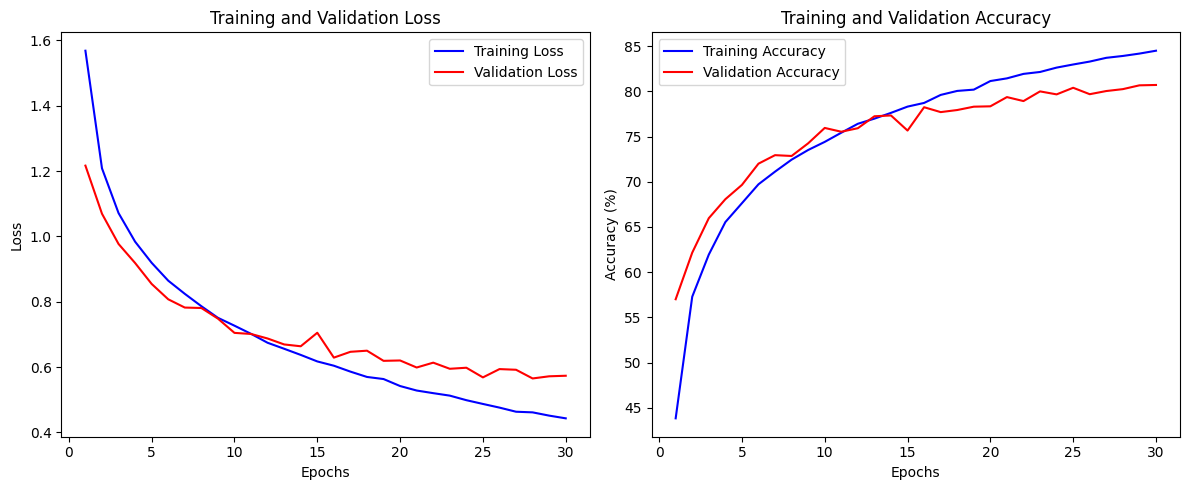

In [97]:
# Plot the training history
plot_training_history(net_3_history)

**Analysis:**

Here's an analysis of the performance based on the charts:

1. **Training and Validation Loss**:
    - The training loss starts at a higher value and rapidly decreases, especially in the initial epochs. As the epochs progress, the rate of decline diminishes, but it continuously goes down.
    - The validation loss also starts at a relatively high value and decreases rapidly in the initial epochs. However, after approximately 10 epochs, the validation loss starts to plateau and shows a slight increase towards the end. This might indicate the onset of overfitting, where the model starts performing exceptionally well on the training data but not as well on the validation data.

2. **Training and Validation Accuracy**:
    - Training accuracy begins at a lower value and shows a steady increase over the epochs. The model's performance on the training set consistently improves, approaching an accuracy of about 85% by epoch 30.
    - The validation accuracy also starts low and rises rapidly in the initial epochs. However, unlike the training accuracy, the validation accuracy starts to plateau after around 15 epochs, hovering around 80%. The gap between the training and validation accuracy towards the end indicates a disparity in performance on the two datasets, further supporting the overfitting observation from the loss plot.

3. **Early Stopping**:
    - The fact that early stopping was triggered at epoch 30 suggests that there was no significant improvement in validation performance for a set number of epochs, reinforcing the idea that the model might have begun overfitting the training data.

**Conclusion**:
The CNN demonstrates promising performance on the training dataset, reaching an accuracy close to 85%. However, its performance on the validation set lags behind, achieving around 80% accuracy which is more than all the other networks in this paper. The divergence between training and validation metrics, especially in the later epochs, indicates potential overfitting.

Future Recommendations:
Strategies like regularization, data augmentation, or dropout could be considered to enhance the generalization capabilities of the model and bridge the performance gap between training and validation sets.

In [98]:
# Save the path
net3_PATH = save_path(network_3)

#### Performance on Test Data

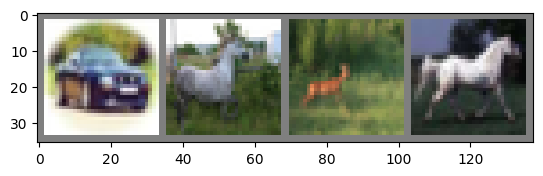

        car         horse          deer         horse


In [106]:
# Select random images from test set
net3_img = show_random_images()

In [101]:
# Instantiate the Enhanced_CNN_Net model
net = CNN_Network_3()

# Load the pre-trained weights and biases from the specified path into the model
net.load_state_dict(torch.load(net3_PATH))

<All keys matched successfully>

In [107]:
# Obtain predictions for the above random images
get_predictions(net, net3_img)

Predicted:    car  horse   deer  horse


**Analysis:**

The network predicted all the four images correctly

In [103]:
# Evaluate test accuracy for the network
accuracy = evaluate_test_accuracy(net)

Accuracy of the network on the 10000 test images: 79 %


In [108]:
# Append the model information to the dataframe
network_performances.loc[len(network_performances)] = ["Network 3", True, accuracy]


<br/>

## 4. Performance Comparision

In [110]:
# performance of all the four CNN networks
network_performances

,cnn_network,data_augmentation,test_accuracy
0,Network 1,False,63.10
1,Network 1,True,64.58
2,Network 2,True,67.03
3,Network 3,True,79.12


**Analysis:**

The table presents the performance (test accuracy) of different CNN architectures (Network 1, Network 2, and Network 3) and the effect of data augmentation on their results. Let's analyze the data:

1. **Network 1**:
    - Without Data Augmentation: Achieves a test accuracy of 63.10%.
    - With Data Augmentation: Experiences a slight improvement in performance to 64.58%. This indicates that introducing data augmentation has a positive impact on the model's generalization, albeit a small one. Moreover, due augmentation of data has significantly reduced overfitting.

2. **Network 2**:
    - It achieves a test accuracy of 67.03%, which is higher than Network 1 with or without data augmentation. This suggests that Network 2's architecture might inherently be better suited for this task compared to Network 1.

3. **Network 3**:
    - Network 3 outperforms both Network 1 and Network 2 by a substantial margin, achieving a test accuracy of 79.12%. This indicates that Network 3's architecture is likely superior for the given problem or dataset compared to the other two.

**Effects of Data Augmentation**:
- Only Network 1 has results for both with and without data augmentation, which allows for a direct comparison. The improvement in test accuracy due to data augmentation is 1.48 percentage points (from 63.10% to 64.58%). This suggests that data augmentation, which introduces variations in the training data and helps in mitigating overfitting, has a positive effect on the model's performance.

**Summary**:
Network 3, with data augmentation, achieves the highest test accuracy among the provided networks, making it the best-performing model in this comparison. Data augmentation seems to enhance the test accuracy, by introducing varied training samples and potentially reducing overfitting. However, the magnitude of improvement from data augmentation may vary based on the network's architecture and the nature of the dataset.